# Specify the files

In [ ]:
import os

os.chdir("/Users/constantin/workspace/Quantification/Benchmarks/DIA/1_10_100_Spectronaut/eval_noise/")
results_dir_sn = "results_ml_annot" #"results"
results_dir_diann_mbr = "../../1_10_100_DIANN_mbr/eval_noise/results_w_ml"
#specnaut_loc = "yeast_report_doublefilt.tsv"
#diann_loc = "../../1_10_100_DIANN_mbr/eval_noise/yeast_report_doublefilt.tsv"
samplemap_sn = "samples.map.tsv"
samplemap_diann = "../../1_10_100_DIANN_mbr/eval_noise/samples.map.tsv"
savedir = "benchmarks2"

input_file = 'yeast_report_doublefilt.tsv'
samplemap_file = "/Users/constantin/workspace/Quantification/Benchmarks/DIA/1_10_100_Spectronaut/eval_noise/samples.map.tsv"
condpair_combinations = [('Y10', 'Y1'), ('Y100', 'Y1'), ('Y100', 'Y10')]
expected_log2fcs = [np.log2(10), np.log2(10), np.log2(100)]


quant_levels_aq = ['mod_seq_charge']#, 'seq', 'gene']
quant_levels_sn = ['spectronaut_precursor']#, 'spectronaut_sequence', 'spectronaut_protein']
quant_levels_diann = ['diann_precursor']#, 'diann_sequence', 'diann_protein']
replace_nans = [True]
distort_every_nth_precursor = [5, np.inf]
predscore_cutoff = None
ml_exclude = False
percentile_to_retain = 0.7


# Prepare the files

In [ ]:
import alphaquant.benchmarking as aqbench

aqbench.retrieve_all_peptides_from_fasta_and_save()

# Run the diffanalyses

In [ ]:
#whole dataset
import alphaquant.diff_analysis_manager as aqmgr
import alphaquant.diffquant_utils as aqutils




aqmgr.run_pipeline(input_file=input_file, samplemap_file=samplemap_file, condpair_combinations=condpair_combinations, results_dir="results_w_ml", runtime_plots=True, normalize=False, minrep=9, use_ml=True) # no normalization because the yeast proteins are shifted


# Evaluate ML performance

In [ ]:
import alphaquant.benchmarking as aqbench
import alphaquant.visualizations as aqplot
import numpy as np
import alphaquant.classify_ions as aqclass
import alphaquant.diffquant_utils as aqutils
import alphaquant.cluster_ions as aqclust
import anytree

def load_tree_assign_predscores(c1, c2, name,results_folder, re_run_assignment  = False,results_folder_diann = None, replace_nans = False, distort_precursor_modulo = np.inf):
    cpair_tree = aqutils.read_condpair_tree(c1, c2, results_folder=results_folder)

    protnodes = cpair_tree.children

    if hasattr(protnodes[0],'predscore') and not re_run_assignment:
        return protnodes

    aqclass.assign_predictability_scores(protnodes,results_folder,name = name, precursor_cutoff=2, fc_cutoff=0, number_splits=2, plot_predictor_performance=True, replace_nans=replace_nans, distort_precursor_modulo = distort_precursor_modulo)
    if results_folder_diann is None:
        aqclust.update_nodes_w_ml_score(protnodes)
    return protnodes


def benchmark_configs_and_datasets(*,results_dir, expected_log2fc,condpairs_to_check, original_input_file, samplemap_reference,  software_used, quant_levels_reference, quant_levels_aq = ['mod_seq_charge'], replace_nans = [True], distort_every_nth_precursor = [5, np.inf], predscore_cutoff = None, ml_exclude = False, percentile_to_retain = 0.7):
    
    
    for idx_condpair in range(len(condpairs_to_check)):
        condpair = condpairs_to_check[idx_condpair]
        for replace_nan in replace_nans:

            for distort_modulo in distort_every_nth_precursor:
                name_analysis_level = get_name(condpair = condpair, replace_nan=replace_nan, distort_number=distort_modulo)
                protein_nodes = load_tree_assign_predscores(c1 = condpair[0], c2 = condpair[1], name= name_analysis_level, results_folder = results_dir, replace_nans= replace_nan,distort_precursor_modulo = distort_modulo, re_run_assignment=True)
                for quant_idx in range(len(quant_level_aq)):

                    quant_level_aq = quant_levels_aq[quant_idx]
                    quant_level_reference = quant_levels_reference[quant_idx]
                    name = name_analysis_level+quant_level_reference
                    print(f"TESTING: {name}")
                    
                    aqbench.compare_aq_to_reference(protein_nodes, expected_log2fc, condpair=condpair, software_used=software_used, name = name, original_input_file=original_input_file, samplemap=samplemap_reference, quant_level_aq=quant_level_aq, quant_level_reference=quant_level_reference, 
                    tolerance_interval = 1, xlim_lower = -1, xlim_upper = 3.5,savedir = savedir,predscore_cutoff = predscore_cutoff, ml_exclude = ml_exclude, percentile_to_retain=percentile_to_retain)
                    


def intersect_with_diann(c1, c2, protnodes,results_folder, results_folder_diann):
    diann_intersect = aqclass.get_intersect_sn_diann_precursors(c1, c2, results_folder, results_folder_diann)
    for protein in protnodes:
        precursors = anytree.findall(protein, filter_= lambda x : (x.type == "mod_seq_charge"))
        for precursor in precursors:
            if precursor.name not in diann_intersect:
                precursor.parent = None


def get_name(condpair, replace_nan, distort_number, diann_intersect_dir = None):
    name = f"{condpair[0]}_{condpair[1]}_distort_every{distort_number}_"
    if replace_nan:
        name+="nanreplace_"
    if diann_intersect_dir:#in the case that e.g. Spectronaut results are overlayed with DIANN results
        if "no_mbr" in diann_intersect_dir:
            name+="diann_intersect_no_mbr"
        else:
            name+="diann_intersect_mbr"
    
    return name








In [ ]:
benchmark_configs_and_datasets(results_dir_sn= results_dir_sn, results_dir_diann_no_mbr=results_dir_diann_no_mbr, results_dir_diann_mbr = results_dir_diann_mbr, 
specnaut_loc = specnaut_loc, diann_loc = diann_loc, samplemap_sn = samplemap_sn, samplemap_diann = samplemap_diann, savedir = savedir)

In [ ]:
import pandas as pd

df = pd.read_csv("/Users/constantin/workspace/Quantification/Benchmarks/DIA/1_10_100_Spectronaut/eval_noise/yeast_report_doublefilt.tsv", sep = "\t", nrows=2)
display(df.columns)

Index(['R.Label', 'PG.Genes', 'PG.Organisms', 'PG.ProteinGroups',
       'PG.Quantity', 'PEP.NrOfMissedCleavages', 'PEP.StrippedSequence',
       'PEP.MS1Channel1', 'PEP.MS2Channel1', 'PEP.MS1Quantity',
       'PEP.MS2Quantity', 'PEP.Quantity', 'PEP.UsedForProteinGroupQuantity',
       'EG.IsDecoy', 'EG.ModifiedSequence', 'EG.PEP', 'EG.Pvalue', 'EG.Qvalue',
       'EG.Svalue', 'EG.ApexRT', 'EG.DatapointsPerPeak', 'EG.DeltaRT',
       'EG.AvgProfileQvalue', 'EG.MaxProfileQvalue', 'EG.MinProfileQvalue',
       'EG.PercentileQvalue', 'EG.IsImputed',
       'EG.ReferenceQuantity (Settings)', 'EG.TargetQuantity (Settings)',
       'EG.TotalQuantity (Settings)', 'EG.UsedForPeptideQuantity',
       'EG.UsedForProteinGroupQuantity', 'EG.Cscore', 'EG.IntCorrScore',
       'EG.Noise', 'FG.Charge', 'FG.FragmentCount', 'FG.Id', 'FG.PrecMz',
       'FG.PrecursorSignalToNoise', 'FG.SignalToNoise', 'FG.ShapeQualityScore',
       'FG.MS1IsotopeIntensities (Measured)', 'FG.MS1IsotopeQuantity',
       '

using input type spectronaut_precursor


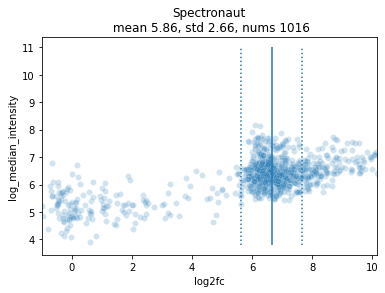

In [ ]:
import pandas as pd
import alphaquant.diffquant_utils as aqutils
import alphaquant.benchmarking as aqbench
import numpy as np
import alphaquant.visualizations as aqplot
import alphaquant.diff_analysis_manager

def filter_score_from_original_df(original_input_file, aq_used_file ,sample_id, precursor_id, c1, c2, samplemap_file, percentile_to_use, quality_id, minrep):
    #load samples
    samplemap = aqutils.load_samplemap(samplemap_file)
    samples_c1 = list(samplemap[[x ==c1 for x in samplemap["condition"]]]["sample"])
    samples_c2 = list(samplemap[[x ==c2 for x in samplemap["condition"]]]["sample"])

    #retrieve ions used by AlphaQuant
    aq_df = pd.read_csv(aq_used_file, sep = '\t')
    aq_df = aqutils.filter_df_to_minrep(aq_df, samples_c1, samples_c2, minrep)

    ions_used_aq = set(aq_df["ion"])

    samplemap = samplemap[[x == c1 or x == c2 for x in samplemap["condition"]]] #only the condition samples remain
    condition_samples = set(samplemap["sample"])
    reference_df_it = pd.read_csv(original_input_file, sep = "\t", chunksize= 100_000)
    reference_dfs = []
    for df_chunk in reference_df_it:
        df_chunk = df_chunk.drop_duplicates(subset = [sample_id, precursor_id])
        #df_chunk = df_chunk[[x in ions_used_aq for x in df_chunk[precursor_id]]]
        df_chunk = df_chunk[[x in condition_samples for x in df_chunk[sample_id]]]
        reference_dfs.append(df_chunk)

    reference_df = pd.concat(reference_dfs, ignore_index=True)

    reference_df_filtered = filter_top_percentile_reference_df(reference_df, precursor_id, quality_id, percentile_to_use)
    filename = f"{original_input_file}_scorefilt_{percentile_to_use :.2f}.tsv"
    reference_df_filtered.to_csv(filename, sep = "\t", index = None)

    return filename


def filter_top_percentile_reference_df(reference_df, precursor_id, quality_id, percentile_to_use):
    groupedref = reference_df.groupby([precursor_id]).mean().reset_index()
    groupedref = groupedref.sort_values(by=quality_id, ascending=False)
    first_sample = list(groupedref[precursor_id][:3])

    cutoff_threshold = int(percentile_to_use * len(groupedref.index))
    best_ranked_ions = list(groupedref[precursor_id][:cutoff_threshold])

    assert (first_sample == best_ranked_ions[:3])

    filtered_df = reference_df[[x in best_ranked_ions for x in reference_df[precursor_id]]]

    return filtered_df


def read_reformat_filtered_df(filtered_file, input_type_to_use, samplemap_file, c1, c2, num_rep):
    samplemap_df = aqutils.load_samplemap(samplemap_file)
    input_df = aqutils.import_data(filtered_file, input_type_to_use=input_type_to_use)
    #input_df, samplemap_df = aqutils.prepare_loaded_tables(input_df, samplemap_df)

    c1_samples = list(samplemap_df[samplemap_df["condition"]==c1]["sample"])
    c2_samples = list(samplemap_df[samplemap_df["condition"]==c2]["sample"])
    annotated_df = aqbench.annotate_fcs_to_wideformat_table(input_df,c1_samples, c2_samples, num_reps = num_rep)
    return annotated_df




samplemap_file = "/Users/constantin/workspace/Quantification/Benchmarks/DIA/1_10_100_Spectronaut/eval_noise/samples.map.tsv"


filtered_file = filter_score_from_original_df(original_input_file="/Users/constantin/workspace/Quantification/Benchmarks/DIA/1_10_100_Spectronaut/eval_noise/yeast_report_doublefilt.tsv", 
aq_used_file="/Users/constantin/workspace/Quantification/Benchmarks/DIA/1_10_100_Spectronaut/eval_noise/yeast_report_doublefilt.tsv.spectronaut_precursor.aq_reformat.tsv",
sample_id="R.Label", precursor_id="FG.Id", c1 = "Y100", c2 = "Y1", samplemap_file =samplemap_file, percentile_to_use=1.0, quality_id='FG.ShapeQualityScore', minrep=9)

#filtered_file= "/Users/constantin/workspace/Quantification/Benchmarks/DIA/1_10_100_Spectronaut/eval_noise/yeast_report_doublefilt.tsv_scorefilt_0.35.tsv"
specnaut_reformat = read_reformat_filtered_df(filtered_file, input_type_to_use='spectronaut_precursor',samplemap_file=samplemap_file,  c1 = "Y100", c2 = "Y1", num_rep=9)

aqplot.plot_fc_intensity_scatter(specnaut_reformat, "Spectronaut", expected_log2fc = np.log2(100), tolerance_interval = 1, xlim_lower=-1, xlim_upper = 3.5)


using input type spectronaut_precursor
0.35 outliers


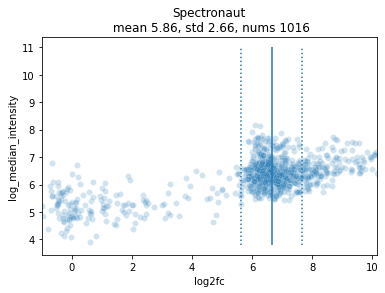

In [ ]:
specnaut_reformat = read_reformat_filtered_df(filtered_file, input_type_to_use='spectronaut_precursor',samplemap_file=samplemap_file,  c1 = "Y100", c2 = "Y1", num_rep=9)
aqbench.count_outlier_fraction(specnaut_reformat, 1, np.log2(100))
aqplot.plot_fc_intensity_scatter(specnaut_reformat, "Spectronaut", expected_log2fc = np.log2(100), tolerance_interval = 1, xlim_lower=-1, xlim_upper = 3.5)

In [ ]:
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',

                              'Parrot', 'Parrot'],

                   'Max Speed': [380., 370., 24., 26.]})

grouped = df.groupby(['Animal'])
display(grouped.groups)
display(grouped.apply(lambda x : len(x)))


{'Falcon': [0, 1], 'Parrot': [2, 3]}

Animal
Falcon    2
Parrot    2
dtype: int64